## StarGAN PyTorch実装を学ぶ
- Reference
  - https://github.com/eriklindernoren/PyTorch-GAN/tree/master/implementations/stargan  


In [32]:
import os
import sys
import datetime
import time
import numpy as np
import pandas as pd
import itertools

In [33]:
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [34]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.autograd as autograd

In [35]:
# for model
import torch.nn as nn
import torch.nn.functional as F
import torch

In [36]:
# for datasets
import glob
import random
#import os
#import numpy as np

from torch.utils.data import Dataset
from PIL import Image

In [37]:
torch.__version__

'1.7.0+cu101'

In [38]:
DATA_DIR_PATH = '/content/drive/My Drive/project/ML/pytorch-gan/data'

OUTPUT_DIR_PATH = os.path.join(DATA_DIR_PATH, '11_out')

In [39]:
os.makedirs(os.path.join(OUTPUT_DIR_PATH, 'images'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR_PATH, 'saved_models'), exist_ok=True)

In [40]:
cuda = True if torch.cuda.is_available() else False

In [41]:
##############################
#           RESNET
##############################
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [
            nn.Conv2d(in_features, in_features, 3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(in_features, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_features, in_features, 3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(in_features, affine=True, track_running_stats=True),
        ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, img_shape=(3, 128, 128), res_blocks=9, c_dim=5):
        super(GeneratorResNet, self).__init__()
        channels, img_size, _ = img_shape

        # Initial convolution block
        model = [
            nn.Conv2d(channels + c_dim, 64, 7, stride=1, padding=3, bias=False),
            nn.InstanceNorm2d(64, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        ]

        # Downsampling
        curr_dim = 64
        for _ in range(2):
            model += [
                nn.Conv2d(curr_dim, curr_dim * 2, 4, stride=2, padding=1, bias=False),
                nn.InstanceNorm2d(curr_dim * 2, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True),
            ]
            curr_dim *= 2

        # Residual blocks
        for _ in range(res_blocks):
            model += [ResidualBlock(curr_dim)]

        # Upsampling
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(curr_dim, curr_dim // 2, 4, stride=2, padding=1, bias=False),
                nn.InstanceNorm2d(curr_dim // 2, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True),
            ]
            curr_dim = curr_dim // 2

        # Output layer
        model += [nn.Conv2d(curr_dim, channels, 7, stride=1, padding=3), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x, c):
        c = c.view(c.size(0), c.size(1), 1, 1)
        c = c.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat((x, c), 1)
        return self.model(x)

In [42]:
##############################
#        Discriminator
##############################
class Discriminator(nn.Module):
    def __init__(self, img_shape=(3, 128, 128), c_dim=5, n_strided=6):
        super(Discriminator, self).__init__()
        channels, img_size, _ = img_shape

        def discriminator_block(in_filters, out_filters):
            """Returns downsampling layers of each discriminator block"""
            layers = [
                nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1),
                nn.LeakyReLU(0.01)
            ]
            return layers

        layers = discriminator_block(channels, 64)
        curr_dim = 64
        for _ in range(n_strided - 1):
            layers.extend(discriminator_block(curr_dim, curr_dim * 2))
            curr_dim *= 2

        self.model = nn.Sequential(*layers)

        # Output 1: PatchGAN
        self.out1 = nn.Conv2d(curr_dim, 1, 3, padding=1, bias=False)

        # Output 2: Class prediction
        kernel_size = img_size // 2 ** n_strided
        self.out2 = nn.Conv2d(curr_dim, c_dim, kernel_size, bias=False)

    def forward(self, img):
        feature_repr = self.model(img)
        out_adv = self.out1(feature_repr)
        out_cls = self.out2(feature_repr)
        return out_adv, out_cls.view(out_cls.size(0), -1)

In [43]:
class CelebADataset(Dataset):
    def __init__(self, root, transforms_=None, mode="train", attributes=None):
        self.transform = transforms.Compose(transforms_)

        self.selected_attrs = attributes
        self.files = sorted(glob.glob("%s/*.jpg" % root))
        #self.files = self.files[:-2000] if mode == "train" else self.files[-2000:]
        self.files = self.files[:-300] if mode == "train" else self.files[-300:]
        self.label_path = glob.glob("%s/*.txt" % root)[0]
        self.annotations = self.get_annotations()

    def get_annotations(self):
        """Extracts annotations for CelebA"""
        annotations = {}
        lines = [line.rstrip() for line in open(self.label_path, "r")]
        self.label_names = lines[1].split()
        for _, line in enumerate(lines[2:]):
            filename, *values = line.split()
            labels = []
            for attr in self.selected_attrs:
                idx = self.label_names.index(attr)
                labels.append(1 * (values[idx] == "1"))
            annotations[filename] = labels
        return annotations

    def __getitem__(self, index):
        filepath = self.files[index % len(self.files)]
        filename = filepath.split("/")[-1]
        img = self.transform(Image.open(filepath))
        label = self.annotations[filename]
        label = torch.FloatTensor(np.array(label))

        return img, label

    def __len__(self):
        return len(self.files)

In [44]:
class Option:
    def __init__(self):
        self.epoch = 0
        #self.n_epochs = 200
        self.n_epochs = 5
        #self.dataset_name = "img_align_celeba"
        self.dataset_name = "celeba"
        self.batch_size = 16
        self.lr = 0.0002
        self.b1 = 0.5
        self.b2 = 0.999
        self.decay_epoch = 100
        self.n_cpu = 8
        self.img_height = 128
        self.img_width = 128
        self.channels = 3
        self.sample_interval = 400
        self.checkpoint_interval = -1
        self.residual_blocks = 6
        self.selected_attrs = ["Black_Hair", "Blond_Hair", "Brown_Hair", "Male", "Young"]
        self.n_critic = 5

opt = Option()

In [45]:
# Configure dataloaders
IMG_ROOT_PATH = os.path.join(DATA_DIR_PATH, opt.dataset_name)

train_transforms = [
    transforms.Resize(int(1.12 * opt.img_height), Image.BICUBIC),
    transforms.RandomCrop(opt.img_height),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

dataloader = DataLoader(
    CelebADataset(
        IMG_ROOT_PATH, transforms_=train_transforms, mode="train", attributes=opt.selected_attrs
    ),
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=opt.n_cpu,
)

val_transforms = [
    transforms.Resize((opt.img_height, opt.img_width), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

val_dataloader = DataLoader(
    CelebADataset(
        IMG_ROOT_PATH, transforms_=val_transforms, mode="val", attributes=opt.selected_attrs
    ),
    batch_size=10,
    shuffle=True,
    num_workers=1,
)

In [46]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)


def criterion_cls(logit, target):
    return F.binary_cross_entropy_with_logits(logit, target, size_average=False) / logit.size(0)

In [47]:
class StarGAN:
    def __init__(self, options, data_loader, val_data_loader, c_dim, img_shape, residual_blocks=9):
        self.history = pd.DataFrame({}, columns=[
            'epoch', 'batch_i',
            'loss_D_adv', 'loss_D_cls',
            'loss_G', 'loss_G_adv', 'loss_G_cls', 'loss_G_rec',
            'elapsed_time'
        ])

        self.img_save_dir = os.path.join(OUTPUT_DIR_PATH, 'images')
        self.model_save_dir = os.path.join(OUTPUT_DIR_PATH, 'saved_models')
        self.G_name = 'generator'
        self.train_cnt = 0

        self.opt = options
        self.data_loader = data_loader
        self.val_data_loader = val_data_loader
        self.c_dim = c_dim
        self.img_shape = img_shape
        self.residual_blocks = residual_blocks

        # Loss functions
        self.criterion_cycle = torch.nn.L1Loss()

        # Loss weights
        self.lambda_cls = 1
        self.lambda_rec = 10
        self.lambda_gp = 10

        # Initialize generator and discriminator
        self.generator = GeneratorResNet(img_shape=self.img_shape, res_blocks=self.residual_blocks, c_dim=self.c_dim)
        self.discriminator = Discriminator(img_shape=self.img_shape, c_dim=self.c_dim)

        if cuda:
            self.generator = self.generator.cuda()
            self.discriminator = self.discriminator.cuda()
            self.criterion_cycle.cuda()

        # if opt.epoch != 0:
        #     # Load pretrained models
        #     G_AB.load_state_dict(torch.load("saved_models/%s/G_AB_%d.pth" % (self.dataset_name, self.epoch)))
        #     G_BA.load_state_dict(torch.load("saved_models/%s/G_BA_%d.pth" % (self.dataset_name, self.epoch)))
        #     D_A.load_state_dict(torch.load("saved_models/%s/D_A_%d.pth" % (self.dataset_name, self.epoch)))
        #     D_B.load_state_dict(torch.load("saved_models/%s/D_B_%d.pth" % (self.dataset_name, self.epoch)))
        # if opt.epoch != 0:
        #     # Load pretrained models
        #     generator.load_state_dict(torch.load("saved_models/generator_%d.pth" % opt.epoch))
        #     discriminator.load_state_dict(torch.load("saved_models/discriminator_%d.pth" % opt.epoch))
        # else:
        self.generator.apply(weights_init_normal)
        self.discriminator.apply(weights_init_normal)

        # Optimizers
        self.optimizer_G = torch.optim.Adam(
            self.generator.parameters(), lr=self.opt.lr, betas=(self.opt.b1, self.opt.b2))
        self.optimizer_D = torch.optim.Adam(
            self.discriminator.parameters(), lr=self.opt.lr, betas=(self.opt.b1, self.opt.b2))

        self.Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

        # for sample_images
        self.label_changes = [
            ((0, 1), (1, 0), (2, 0)),  # Set to black hair
            ((0, 0), (1, 1), (2, 0)),  # Set to blonde hair
            ((0, 0), (1, 0), (2, 1)),  # Set to brown hair
            ((3, -1),),  # Flip gender
            ((4, -1),),  # Age flip
        ]

    def train(self, n_epochs, n_critic, sample_interval=-1):
        self.train_cnt += 1

        print(datetime.datetime.now().isoformat(), 'Start', self.train_cnt)

        start_datetime = datetime.datetime.now()
        start_time = time.time()

        step_cnt = 1

        for epoch in range(1, n_epochs+1):

            for batch_i, (imgs, labels) in enumerate(self.data_loader, 1):
                # Model inputs
                imgs = Variable(imgs.type(self.Tensor))
                labels = Variable(labels.type(self.Tensor))

                # Sample labels as generator inputs
                sampled_c = Variable(self.Tensor(np.random.randint(0, 2, (imgs.size(0), self.c_dim))))

                # Generate fake batch of images
                fake_imgs = self.generator(imgs, sampled_c)

                # ---------------------
                #  Train Discriminator
                # ---------------------
                self.optimizer_D.zero_grad()

                # Real images
                real_validity, pred_cls = self.discriminator(imgs)
                # Fake images
                fake_validity, _ = self.discriminator(fake_imgs.detach())
                # Gradient penalty
                gradient_penalty = self.compute_gradient_penalty(self.discriminator, imgs.data, fake_imgs.data)
                # Adversarial loss
                loss_D_adv = -torch.mean(real_validity) + torch.mean(fake_validity) + self.lambda_gp * gradient_penalty
                # Classification loss
                loss_D_cls = criterion_cls(pred_cls, labels)
                # Total loss
                loss_D = loss_D_adv + self.lambda_cls * loss_D_cls

                loss_D.backward()
                self.optimizer_D.step()

                self.optimizer_G.zero_grad()

                # Every n_critic times update generator
                if batch_i % n_critic == 0:

                    # -----------------
                    #  Train Generator
                    # -----------------

                    # Translate and reconstruct image
                    gen_imgs = self.generator(imgs, sampled_c)
                    recov_imgs = self.generator(gen_imgs, labels)
                    # Discriminator evaluates translated image
                    fake_validity, pred_cls = self.discriminator(gen_imgs)
                    # Adversarial loss
                    loss_G_adv = -torch.mean(fake_validity)
                    # Classification loss
                    loss_G_cls = criterion_cls(pred_cls, sampled_c)
                    # Reconstruction loss
                    loss_G_rec = self.criterion_cycle(recov_imgs, imgs)
                    # Total loss
                    loss_G = loss_G_adv + self.lambda_cls * loss_G_cls + self.lambda_rec * loss_G_rec

                    loss_G.backward()
                    self.optimizer_G.step()

                    # --------------
                    #  Log Progress
                    # --------------

                    # Determine approximate time left
                    batches_done = epoch * len(dataloader) + batch_i
                    batches_left = n_epochs * len(dataloader) - batches_done
                    time_left = datetime.timedelta(seconds=batches_left * (time.time() - start_time) / (batches_done + 1))

                    elapsed_time = datetime.datetime.now() - start_datetime

                    # Print log
                    sys.stdout.write(
                        "\r[Epoch %d/%d] [Batch %d/%d] [D adv: %f, aux: %f] [G loss: %f, adv: %f, aux: %f, cycle: %f] ETA: %s"
                        % (
                            epoch,
                            n_epochs,
                            batch_i,
                            len(dataloader),
                            loss_D_adv.item(),
                            loss_D_cls.item(),
                            loss_G.item(),
                            loss_G_adv.item(),
                            loss_G_cls.item(),
                            loss_G_rec.item(),
                            time_left,
                        )
                    )

                    self.history = self.history.append({
                        'epoch':   epoch,
                        'batch_i': batch_i,
                        'loss_D_adv': loss_D_adv.item(),
                        'loss_D_cls': loss_D_cls.item(),
                        'loss_G':     loss_G.item(),
                        'loss_G_adv': loss_G_adv.item(),
                        'loss_G_cls': loss_G_cls.item(),
                        'loss_G_rec': loss_G_rec.item(),
                        'elapsed_time': elapsed_time
                    }, ignore_index=True)

                    # If at sample interval sample and save image
                    # if batches_done % opt.sample_interval == 0:
                    #     sample_images(batches_done)
                    if sample_interval > 0 and batches_done % sample_interval == 0:
                        self.sample_images(epoch, batch_i)

                # if sample_interval > 0 and step_cnt % sample_interval == 0:
                #     self.sample_images(epoch, batch_i)

                step_cnt += 1

            # if opt.checkpoint_interval != -1 and epoch % opt.checkpoint_interval == 0:
            #     # Save model checkpoints
            #     torch.save(generator.state_dict(), "saved_models/generator_%d.pth" % epoch)
            #     torch.save(discriminator.state_dict(), "saved_models/discriminator_%d.pth" % epoch)

        print('')
        print(datetime.datetime.now().isoformat(), 'End')

    def compute_gradient_penalty(self, D, real_samples, fake_samples):
        """Calculates the gradient penalty loss for WGAN GP"""
        # Random weight term for interpolation between real and fake samples
        alpha = self.Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
        # Get random interpolation between real and fake samples
        interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
        d_interpolates, _ = D(interpolates)
        fake = Variable(self.Tensor(np.ones(d_interpolates.shape)), requires_grad=False)

        # Get gradient w.r.t. interpolates
        gradients = autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]
        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

        return gradient_penalty

    def sample_images(self, epoch, batch_i, n_row=5):
        """Saves a generated sample of domain translations"""
        val_imgs, val_labels = next(iter(val_dataloader))
        val_imgs = Variable(val_imgs.type(self.Tensor))
        val_labels = Variable(val_labels.type(self.Tensor))

        img_samples = None

        for i in range(10):
            img, label = val_imgs[i], val_labels[i]

            # Repeat for number of label changes
            imgs = img.repeat(self.c_dim, 1, 1, 1)
            labels = label.repeat(self.c_dim, 1)

            # Make changes to labels
            for sample_i, changes in enumerate(self.label_changes):
                for col, val in changes:
                    labels[sample_i, col] = 1 - labels[sample_i, col] if val == -1 else val

            # Generate translations
            gen_imgs = self.generator(imgs, labels)

            # Concatenate images by width
            gen_imgs = torch.cat([x for x in gen_imgs.data], -1)
            img_sample = torch.cat((img.data, gen_imgs), -1)

            # Add as row to generated samples
            img_samples = img_sample if img_samples is None else torch.cat((img_samples, img_sample), -2)

        file_name = os.path.join(self.img_save_dir, '{}_{}_{}.png'.format(self.train_cnt, epoch, batch_i))
        save_image(img_samples.view(1, *img_samples.shape), file_name, normalize=True)

    def plot_hisotry(self, columns=[]):
        if len(columns) == 0:
            columns = ['loss_G']
        self.history[columns].plot()

    def save_models(self, file_suffix=None):
        self.save_state_dict(self.generator, self.G_name, file_suffix)

    def save_state_dict(self, model, model_name, file_suffix=None):
        file_path = os.path.join(self.model_save_dir, self._create_model_file_name(model_name, file_suffix))
        torch.save(model.state_dict(), file_path)
        print('Model saved.', model_name)

    def _create_model_file_name(self, model_name, suffix=None):
        processor = 'gpu' if cuda else 'cpu'

        if suffix:
            return '{}_{}_{}.pth'.format(model_name, processor, suffix)
        else:
            return '{}_{}.pth'.format(model_name, processor)

In [48]:
n_epochs = 100
sample_interval = 40
c_dim = len(opt.selected_attrs)
img_shape = (opt.channels, opt.img_height, opt.img_width)

gan = StarGAN(opt, dataloader, val_dataloader, c_dim, img_shape)
gan.train(n_epochs, opt.n_critic, sample_interval)

2020-11-06T10:19:09.017662 Start 1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


[Epoch 100/100] [Batch 40/44] [D adv: -3.504924, aux: 1.419137] [G loss: 5.368249, adv: -1.212500, aux: 4.305583, cycle: 0.227517] ETA: -1 day, 23:59:51.226986
2020-11-06T10:35:24.344090 End


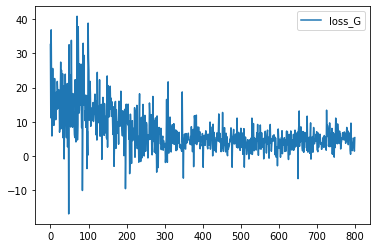

In [49]:
gan.plot_hisotry()

#gan.save_models()

In [50]:
gan.history

,epoch,batch_i,loss_D_adv,loss_D_cls,loss_G,loss_G_adv,loss_G_cls,loss_G_rec,elapsed_time
0,1,5,-10.316227,2.759251,32.623875,20.737658,5.417288,0.646893,0 days 00:00:01.766100
1,1,10,-9.568769,7.161153,11.160994,-2.065978,6.925392,0.630158,0 days 00:00:02.779565
2,1,15,-20.427429,13.388840,36.919426,15.041546,15.779847,0.609803,0 days 00:00:03.793368
3,1,20,-22.359411,4.182434,22.492174,2.573340,14.657975,0.526086,0 days 00:00:04.805506
4,1,25,-3.924501,3.820753,5.839000,-5.461776,6.926534,0.437424,0 days 00:00:05.817586
...,...,...,...,...,...,...,...,...,...
795,100,20,-4.846486,1.772813,5.248790,-1.938187,4.610620,0.257636,0 days 00:16:09.975166
796,100,25,-4.046900,1.287645,4.994015,-2.711327,5.486651,0.221869,0 days 00:16:10.989691
797,100,30,-5.123595,1.675663,2.504709,-4.187431,4.495428,0.219671,0 days 00:16:12.001360
798,100,35,-4.403944,2.543098,1.418570,-4.078428,3.418990,0.207801,0 days 00:16:13.012432
